In [92]:
import os
#import gradio as gr
#import fire
from enum import Enum
from threading import Thread
from transformers import AutoModelForCausalLM, AutoTokenizer
from auto_gptq import AutoGPTQForCausalLM
from llama_cpp import Llama
from huggingface_hub import hf_hub_download
from transformers import TextIteratorStreamer
#from llama_chat_format import format_to_llama_chat_style
from ctransformers import AutoModelForCausalLM
import json
import pandas as pd
import os
import re
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
import numpy as np


In [93]:
# For demonstraion purpose we use smaller version of LLama
# but it can be easily changed with any version depending on the available resources
llm = AutoModelForCausalLM.from_pretrained("TheBloke/sheep-duck-llama-2-13B-GGUF", model_file="sheep-duck-llama-2-13b.Q4_K_M.gguf", model_type="llama", gpu_layers=50)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

ggml_cuda_set_main_device: using device 0 (NVIDIA A100 80GB PCIe) as main device


In [22]:
def fewRel(path):
    data_list = []  # Create a list to collect dictionaries for each row
    sentences = []
    relations = []
    entities = []
    data = {}
    for filename in os.listdir(path):
        if not filename.endswith('.json'):
            continue
        fullname = os.path.join(path, filename)
        
        with open(fullname) as f:
            fewRel_corpus = json.load(f)
            
            for relation, value in fewRel_corpus.items():
                for row in value:
                    sentences.append(row['tokens'])
                    relations.append(relation)
                    entities.append((row['h'][0].strip(),row['t'][0].strip()))
        data['sentence'] = sentences
        data['relation'] = relations
        data['entities'] = entities
    
    return data

In [23]:
data = fewRel('data/')

In [24]:
df = pd.DataFrame(data)

In [31]:
df.head(1)

,sentence,relation,entities
0,"[Merpati, flight, 106, departed, Jakarta, (, C...",P931,"(tjq, tanjung pandan)"


In [35]:
def random_rows_per_category(group):
    return group.sample(n=1, random_state=42) 

In [99]:
random_rows = df.groupby('relation', group_keys=False).apply(random_rows_per_category)


In [100]:
random_rows

,sentence,relation,entities
42858,"[The, ICAC, has, jurisdiction, over, state, an...",P1001,"(icac, new south wales)"
41458,"["", See, also, :, "", Peter, Artedi, (, 1705–17...",P101,"(peter artedi, ichthyology)"
21158,"[Bhupinder, Singh, Hooda, (, born, 15, Septemb...",P102,"(bhupinder singh hooda, indian national congress)"
40058,"[It, belongs, to, the, hobby, group, ,, a, rat...",P105,"(hobby, subgenus)"
25358,"[Jaume, Serra, Serra, (, born, June, 11, ,, 19...",P106,"(jaume serra serra, politician)"
...,...,...,...
35858,"[Adila, Fachiri, made, a, recording, of, the, ...",P86,"(10th violin sonata, beethoven)"
158,"[Hill, had, left, his, luggage, at, Lee, Bird,...",P931,"(lee bird field, north platte, nebraska)"
26758,"[He, was, born, in, Christiania, as, a, son, o...",P937,"(carl johan michelet, christiania)"
33758,"[In, Over, the, river, Seeve, flows, into, the...",P974,"(elbe, seeve)"


### Entities remain the same

In [ ]:
example = "'The FBI has jurisdiction over federal and local government in Texas.' is augumented to 'he CCB has jurisdiction over regional and local government in Brazil.'"

In [83]:
question = 'Please augment 3 syntactically and semantically correct sentences, each distinct from the preceding one,by introducing separate named entities:' + example + ' text ='

In [101]:
all_augumented_data = []
for i in range(10):
    random_rows = df.groupby('relation', group_keys=False).apply(random_rows_per_category)
    for index, row in random_rows.iterrows():
        single_aug_data = {}
        sent = ' '.join(row['sentence'])
        augumented_text = process_data(llm(question + sent))
        #print(process_data(augumented_text))
        single_aug_data['sentences'] = augumented_text
        single_aug_data['relation'] = row['relation']
        single_aug_data['entities'] = row['entities']
       # output = augumented_text +", " + row['relation'] + ", " +  row['entities'][0] +", " +  row['entities'][1]
        all_augumented_data.append(single_aug_data)

640

In [89]:
def process_data(text):
    sentences = re.split(r'\d+\.\s+', text)
    sentences = [sentence for sentence in sentences if sentence.strip()]    
    return sentences

In [136]:
def save(file_path,data):
    with open(file_path, "w") as json_file:
        json.dump(data, json_file)

    print(f'Data saved to {file_path}')

In [106]:
def nytFb(path):
    dist = "train"
    
    temp_sent = ""
    
    temp_rel = ""
    data = {}
    data_list = []  # Create a list to collect dictionaries for each row
    sentences = []
    relations = []
    entities = []
   
    for filename in os.listdir(path):
        if not filename.endswith('.json'): continue
        fullname = os.path.join(path, filename)
       
        if filename == "test.json":
            dist = 'test'
        elif filename == "train.json":
            dist = 'train'
        else:
            dist = 'valid'
        data2 = pd.read_json(r''+ fullname, lines=True)
        print(data2.head())
        return data2
       
    return data
   

In [107]:
data_nyt = nytFb('data/nyt/')

                                            sentText  \
0  Massachusetts ASTON MAGNA Great Barrington ; a...   
1  North Carolina EASTERN MUSIC FESTIVAL Greensbo...   
2  It will be the final movie credited to Debra H...   
3  In a 3-0 victory over the Crew on Saturday in ...   
4  The United States ambassador to Mexico , Tony ...   

                                           articleId  \
0  /m/vinci8/data1/riedel/projects/relation/kb/ny...   
1  /m/vinci8/data1/riedel/projects/relation/kb/ny...   
2  /m/vinci8/data1/riedel/projects/relation/kb/ny...   
3  /m/vinci8/data1/riedel/projects/relation/kb/ny...   
4  /m/vinci8/data1/riedel/projects/relation/kb/ny...   

                                    relationMentions  \
0  [{'em1Text': 'Annandale-on-Hudson', 'em2Text':...   
1  [{'em1Text': 'North Carolina', 'em2Text': 'Gre...   
2  [{'em1Text': 'Debra Hill', 'em2Text': 'Haddonf...   
3  [{'em1Text': 'Ohio', 'em2Text': 'Columbus', 'l...   
4  [{'em1Text': 'Mexico', 'em2Text': 'Nuevo La

In [114]:
nyt_df = pd.DataFrame(columns=['sentences', 'relation', 'entities'])

# Loop through the original DataFrame and perform data manipulation
for index, row in data_nyt.iterrows():
    # Perform your data manipulation here
    sentence = row['sentText']
    relation = row['relationMentions'][0]['label'].split('/')[-1] 
    ent1 = row['entityMentions'][0]['text']
    ent2 = row['entityMentions'][1]['text']
    entities = (ent1, ent2)

    # Create a temporary DataFrame for the current row
    temp_df = pd.DataFrame({'sentences': [sentence], 'relation': [relation], 'entities': [entities]})

    # Concatenate the temporary DataFrame with the new_df
    nyt_df = pd.concat([nyt_df, temp_df], ignore_index=True)

In [116]:
nyt_df.head()

,sentences,relation,entities
0,Massachusetts ASTON MAGNA Great Barrington ; a...,contains,"(Bard College, Annandale-on-Hudson)"
1,North Carolina EASTERN MUSIC FESTIVAL Greensbo...,contains,"(North Carolina, Greensboro)"
2,It will be the final movie credited to Debra H...,place_of_birth,"(Debra Hill, Haddonfield)"
3,In a 3-0 victory over the Crew on Saturday in ...,contains,"(Columbus, Ohio)"
4,"The United States ambassador to Mexico , Tony ...",contains,"(United States, Mexico)"


In [143]:
from tqdm import tqdm
def augument(df, num_iterations = 10):
# Define the number of iterations
    

    # Create an empty list to store augmented data
    all_augmented_data = []

    # Iterate using tqdm for a progress bar
    for i in tqdm(range(num_iterations), desc="Processing"):
        random_rows = df.groupby('relation', group_keys=False).apply(random_rows_per_category)

        for index, row in tqdm(random_rows.iterrows()):
            single_aug_data = {}
            sent = row['sentences']
            augumented_text = process_data(llm(question + sent))

            single_aug_data['sentences'] = augumented_text
            single_aug_data['relation'] = row['relation']
            single_aug_data['entities'] = row['entities']

            all_augmented_data.append(single_aug_data)
    return all_augmented_data

In [119]:
len(all_augmented_data)

240

In [122]:
category_counts = nyt_df['relation'].value_counts()

print(category_counts)

relation
contains                    30240
nationality                  5219
place_lived                  5024
company                      3971
capital                      2430
neighborhood_of              2108
place_of_birth               1580
administrative_divisions     1518
country                      1517
place_of_death               1023
children                      381
founders                      377
place_founded                 318
major_shareholder_of           98
teams                          88
location                       86
major_shareholders             84
religion                       53
advisors                       34
geographic_distribution        26
ethnicity                       9
people                          9
profession                      2
industry                        1
Name: count, dtype: int64


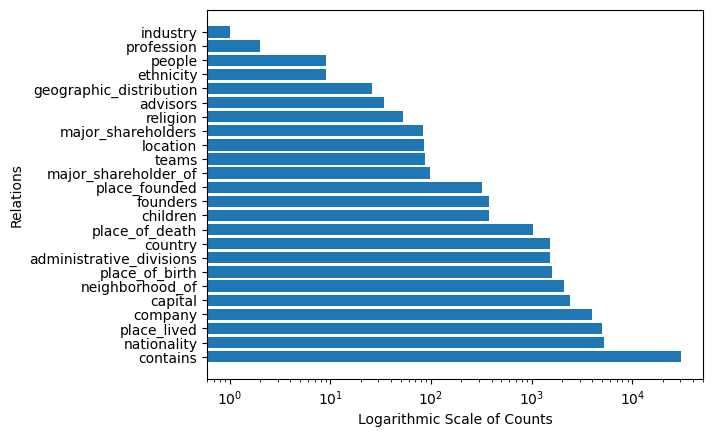

In [127]:
import matplotlib.pyplot as plt

plt.barh(category_counts.index, category_counts.values)
plt.xscale('log')  # Use a logarithmic scale on the x-axis

# Add labels and title
plt.ylabel('Relations')
plt.xlabel('Logarithmic Scale of Counts')
#plt.title('Relation Distribution (Logarithmic Scale)')
plt.savefig('nyt_relation_distribution.pdf', format='pdf', dpi=300, bbox_inches='tight')

# Show the chart
plt.show()

In [144]:
threshold = 100

# Filter categories with counts less than the threshold
categories_below_threshold = category_counts[category_counts < threshold]

# Create two separate DataFrames based on the filter
df_below_threshold = nyt_df[nyt_df['relation'].isin(categories_below_threshold.index)]
df_above_threshold = nyt_df[~nyt_df['relation'].isin(categories_below_threshold.index)]


In [145]:
augumented_data = augument(df_below_threshold,20)

Processing:   0%|          | 0/20 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:09,  9.00s/it]
2it [00:17,  8.82s/it]
3it [00:25,  8.53s/it]
4it [00:34,  8.38s/it]
5it [00:42,  8.35s/it]
6it [00:49,  7.79s/it]
7it [00:56,  7.75s/it]
8it [01:02,  7.26s/it]
9it [01:10,  7.46s/it]
10it [01:19,  7.84s/it]
11it [01:27,  7.96s/it]
Processing:   5%|▌         | 1/20 [01:27<27:43, 87.56s/it]
0it [00:00, ?it/s]
1it [00:09,  9.00s/it]
2it [00:17,  8.82s/it]
3it [00:25,  8.53s/it]
4it [00:34,  8.38s/it]
5it [00:42,  8.35s/it]
6it [00:49,  7.89s/it]
7it [00:54,  7.10s/it]
8it [01:02,  7.40s/it]
9it [01:10,  7.56s/it]
10it [01:19,  7.91s/it]
11it [01:20,  7.30s/it]
Processing:  10%|█         | 2/20 [02:47<24:59, 83.30s/it]
0it [00:00, ?it/s]
1it [00:09,  9.00s/it]
2it [00:17,  8.82s/it]
3it [00:25,  8.52s/it]
4it [00:33,  8.22s/it]
5it [00:41,  8.25s/it]
6it [00:49,  8.05s/it]
7it [00:57,  7.92s/it]
8it [01:04,  7.68s/it]
9it [01:12,  7.76s/it]
10it [01:21,  8.05s/it]
11it [01:28,  8.05s/it]
Processin

In [146]:
file_path = "augumented_data/nyt_less100_100Plus_llama13_data_updated.json"
save(file_path,augumented_data)

Data saved to augumented_data/nyt_less100_100Plus_llama13_data_updated.json


In [138]:
len(augumented_data)

480

In [140]:
random_rows = df_below_threshold.groupby('relation', group_keys=False).apply(random_rows_per_category)